#  VIBRATION DATA ANOMALY DETECTION USING TENSORFLOW

This notebook proposes a methodology for the processing of vibration data files produced by accelerometers and aims at making a diagnosis of a test device – a refrigerator compressor – which is being monitored every hour. In order for this notebook to be correctly reproduced, the data files should be placed in a folder called "DataVB-collection" and the folder should be in the same directory of the notebook.

The data comprises 20 .csv files each containing one data collection, i.e., about 12,700 measurements of acceleration along 3 axes – x, y and z – made during circa 1 minute.

The complete set of files corresponds to collections made every hour, from 22:34 of 5/16/2020 to 18:01 of 5/17/2020, of a refrigerator compressor. In the following we see a description of the files.

## File Content

In [1]:
# Here we run the import commands for the whole notebook:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from scipy.signal import find_peaks

# Let's import the first file and put it in a Pandas dataframe.
df = pd.read_csv('DataVB-collection/1589679298-1589679343.csv', names=["x","y","z","c"], sep=",",dtype={"x": np.float32, "y": np.float32, "z": np.float32, "c": np.float32})
df.head()

,x,y,z,c
0,-8.84,0.97,0.02,38.599998
1,-8.81,1.40,-0.49,38.549999
2,-8.91,0.72,-1.68,38.650002
3,-9.59,-0.79,-2.61,38.599998
4,-9.85,-1.53,-2.27,38.599998


## Descriptive Statistics
As we see bellow, this collection has 12,727 measurements of acceleration (in m/s^2) (this count is typical for the whole set), each in one of the directions x, y or z. The column "c" (temperature) was disregarded. 

The figures here shown (comprising data on percentiles, central tendency and dispersion) are representative of the whole subset of files in which the fridge was on (as checked later). Similar descriptions could be provided for the subset in which the fridge was off (I opted instead for a visual presentation, see bellow).

In any case, the main difference between uptime and downtime is the amplitude of oscillation, here described by the standard deviation (std), which is at least one order of magnitude greater for the uptime data (more in the following).

In [3]:
df.describe()

,x,y,z,c
count,12727.000000,12727.000000,12727.000000,12727.000000
mean,-9.290692,-0.031465,-1.285049,39.289272
std,0.399983,1.068832,1.007616,0.186831
min,-9.950000,-1.670000,-2.860000,38.509998
25%,-9.720000,-1.080000,-2.315000,39.209999
50%,-9.290000,-0.050000,-1.290000,39.310001
75%,-8.860000,1.050000,-0.250000,39.450001
max,-8.630000,1.640000,0.270000,39.680000


## Missing values
I repeated the following check for a subset of files and concluded that the set of files essentially has no missing or NaN values:

In [4]:
# In this demonstration we check the "x" series of the first file.
bool_series = pd.isnull(df["x"]) 
df[bool_series] 

,x,y,z,c


## I. SPECTRAL ANALYSIS OF THE COMPRESSOR
Let's create a function that takes as input the measurement times, the signal, the sample frequency, the axis identifier and the initial time of the collection, calculates the Fast Fourier Transform and outputs:
1. The time domain plot.
2. The frequency domain plot.

In [5]:
def time_freq_plot(tm, ampl1, smpl_freq, axis, time1):
    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    plt.subplots_adjust(hspace=.5)
    
    # Time domain plot
    axes[0].set_title('Time domain of '+axis+'-axis at '+time.ctime(time1)) # each collection will be identified by the time of start
    axes[0].plot(tm, ampl1)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (m/s^2)')
    
    #FFT
    ft_ = np.fft.fft(ampl1 - ampl1.mean()) / len(ampl1)  # Demeaning, FFT and amplitude normalization
    ft_ = ft_[range(int(len(ampl1)/2))]   # Excluding sampling frequency
    tp_cnt = len(ampl1)
    val_ = np.arange(int(tp_cnt / 2))
    tm_period_ = tp_cnt / smpl_freq
    freq_ = val_ / tm_period_
    
    # Frequency domain plot
    axes[1].set_title('Fourier transform of '+axis+'-axis at '+time.ctime(time1))
    axes[1].plot(freq_, abs(ft_))
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Amplitude')
    
    Heights = abs(ft_)
    peaks, _ = find_peaks(Heights, height=0.01, distance=400)
    axes[1].plot(freq_[peaks], Heights[peaks], "x")

    for peak in peaks:
        axes[1].annotate(str(round(freq_[peak], 1))+' Hz', xy=(freq_[peak], Heights[peak]), xytext=(freq_[peak]+2, Heights[peak]-0.01))
    plt.show()

The following code will apply the function time_freq_plot() for each file in the folder "DataVB-collection":

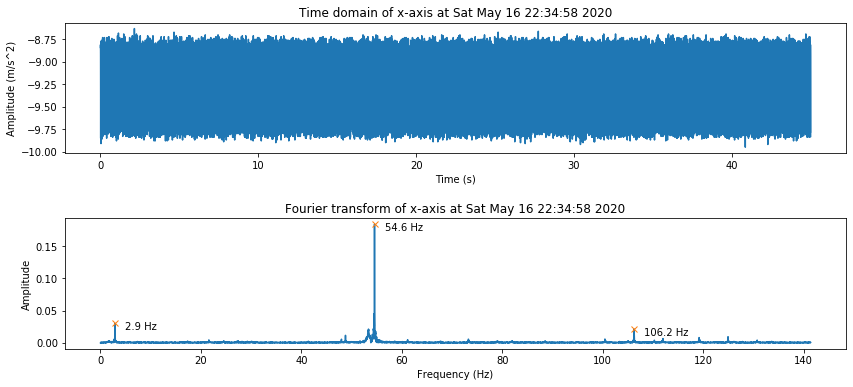

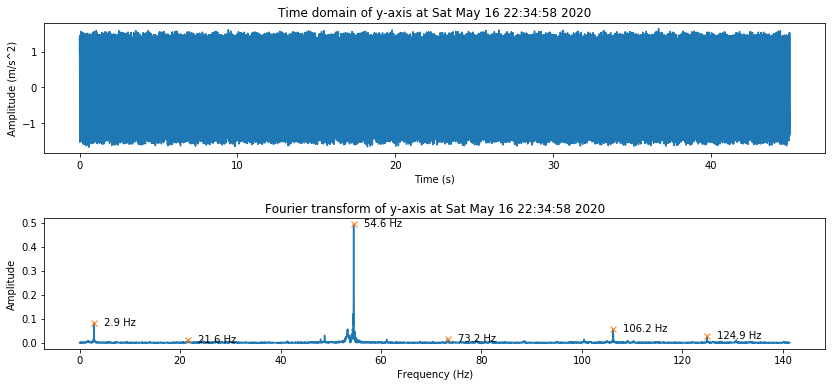

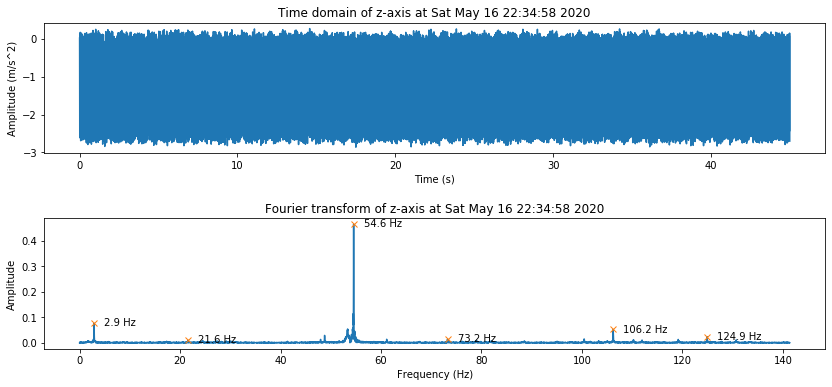

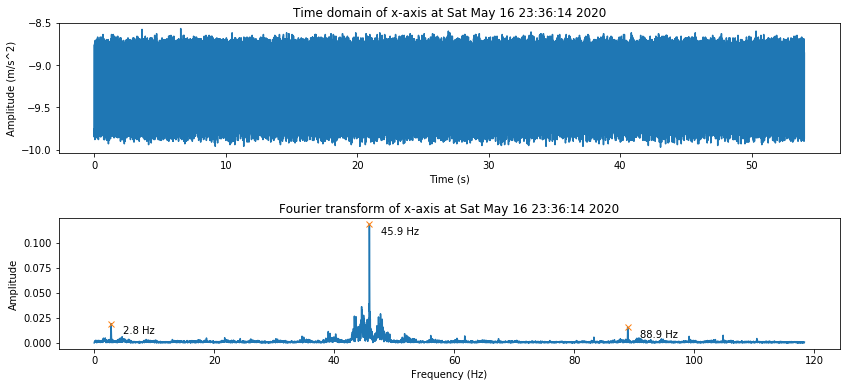

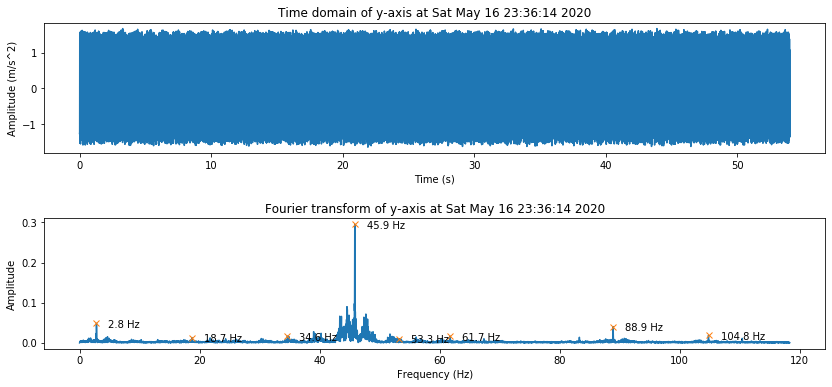

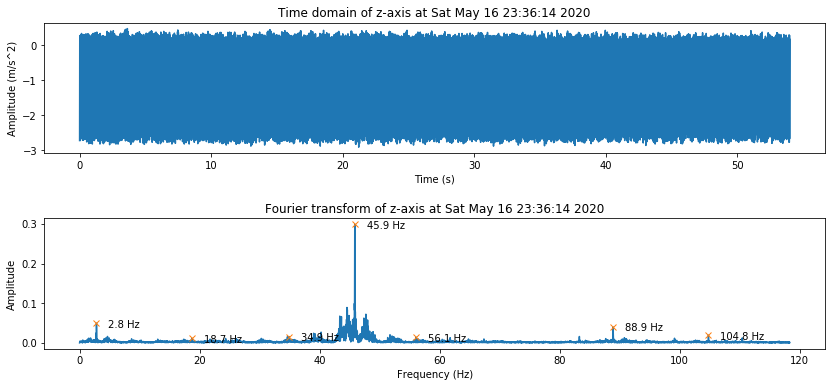

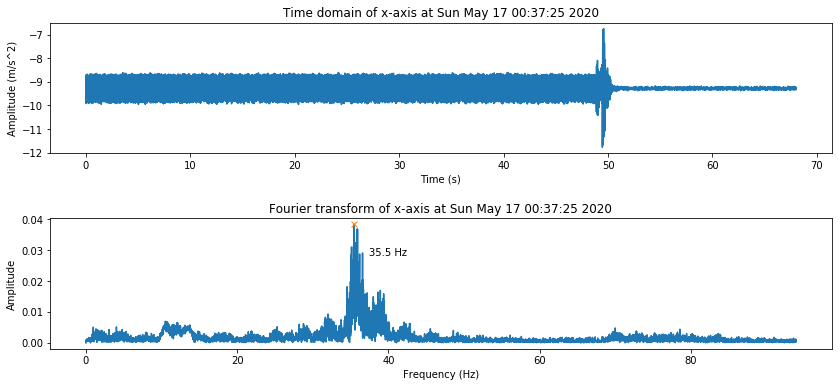

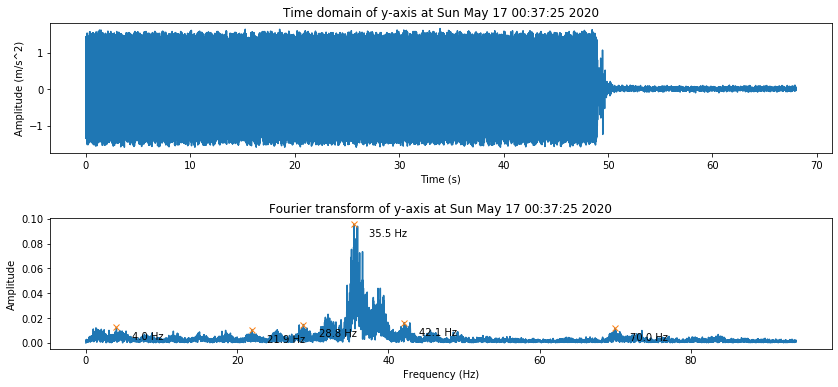

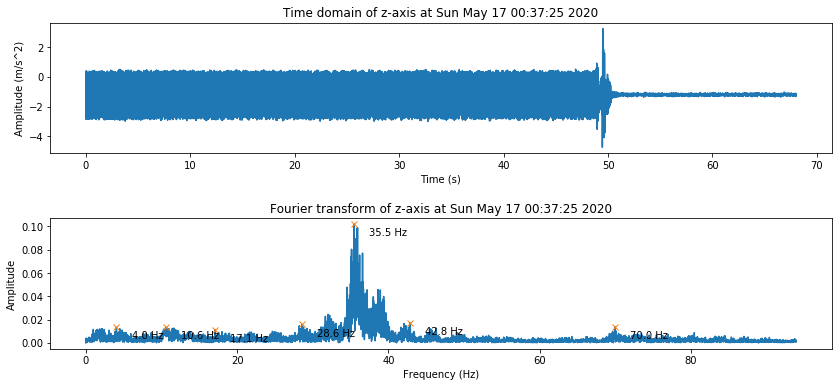

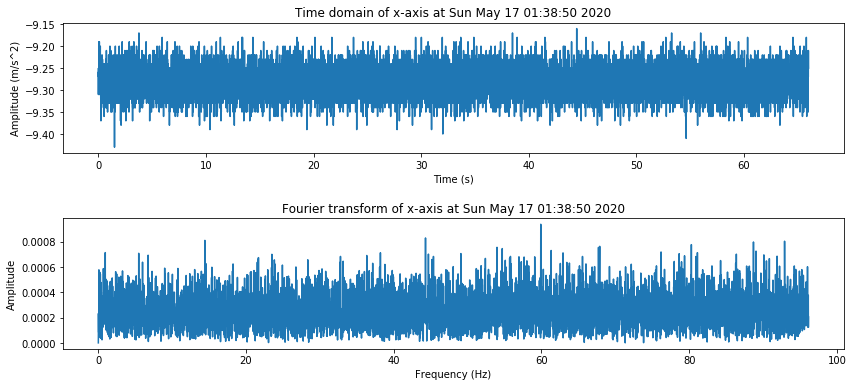

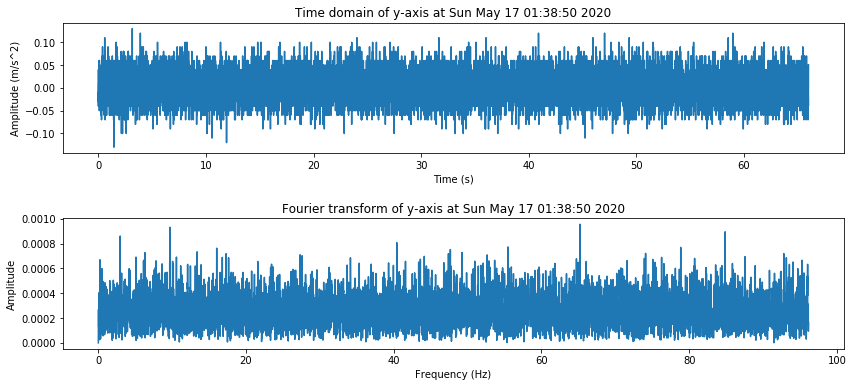

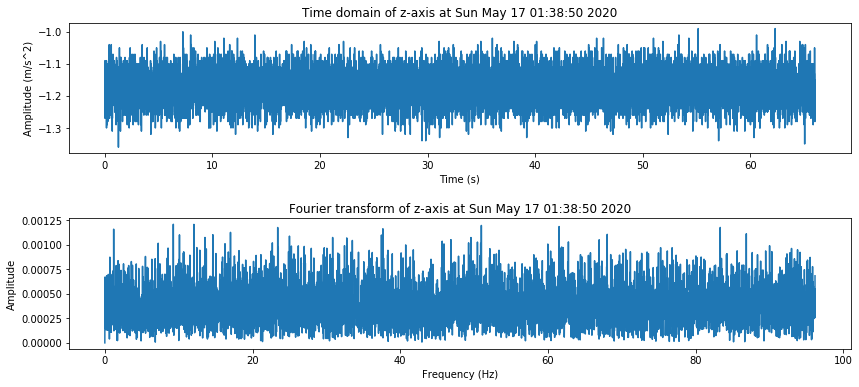

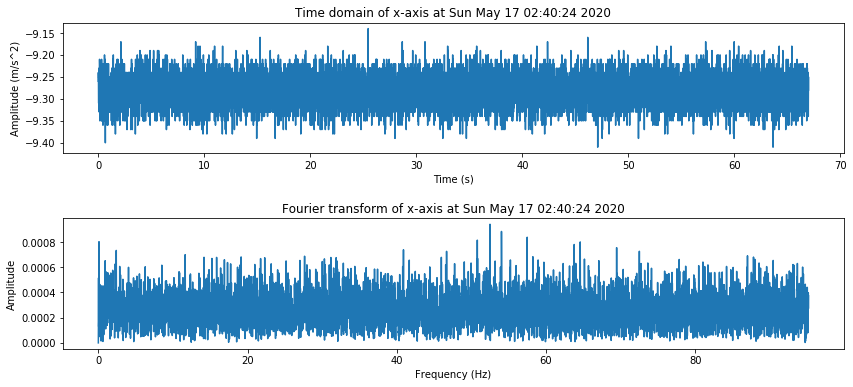

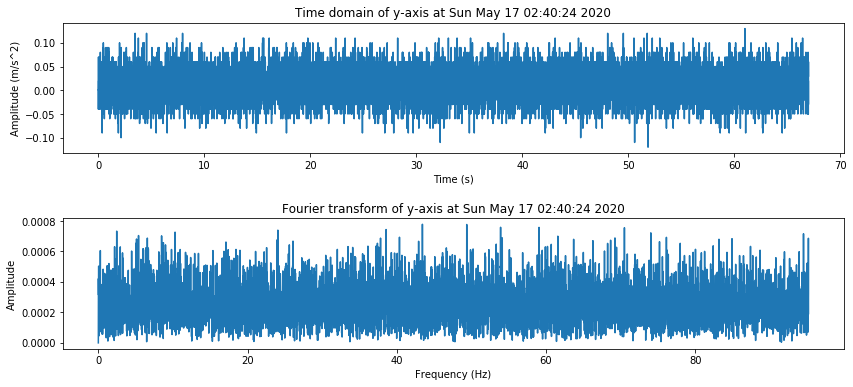

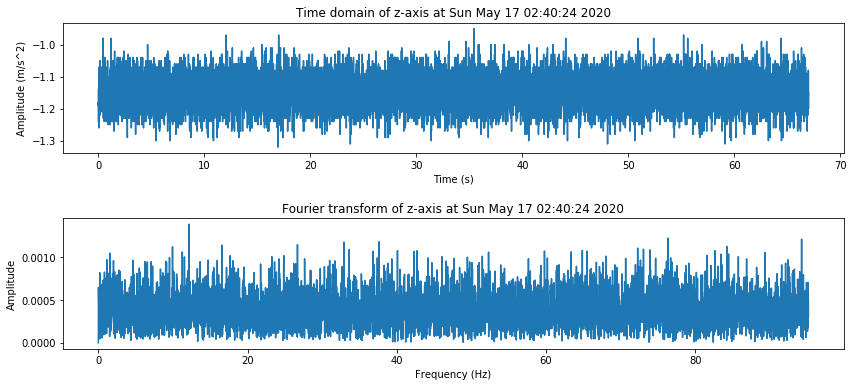

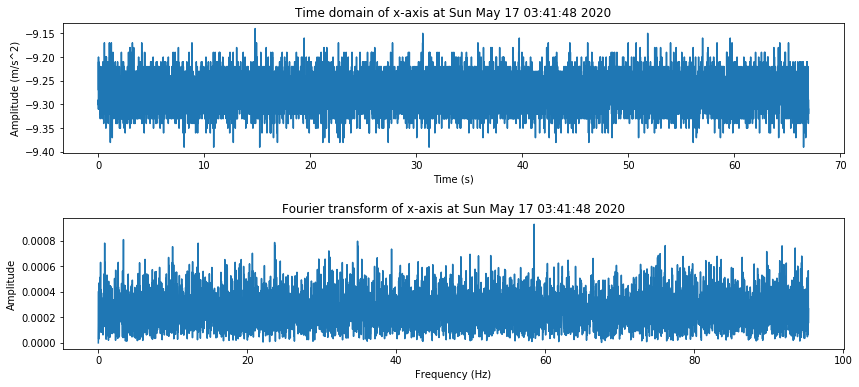

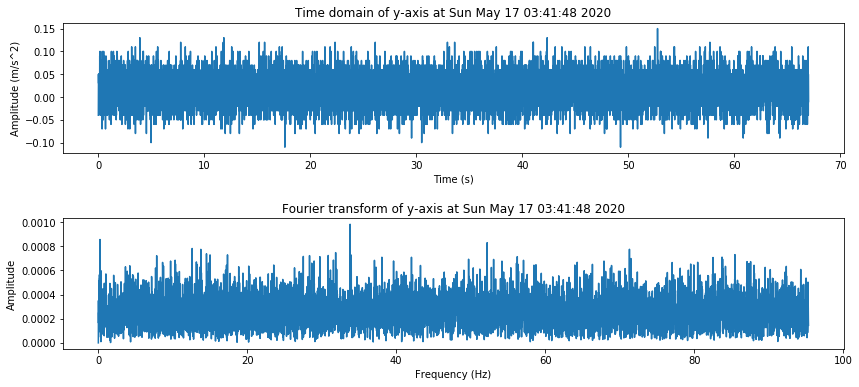

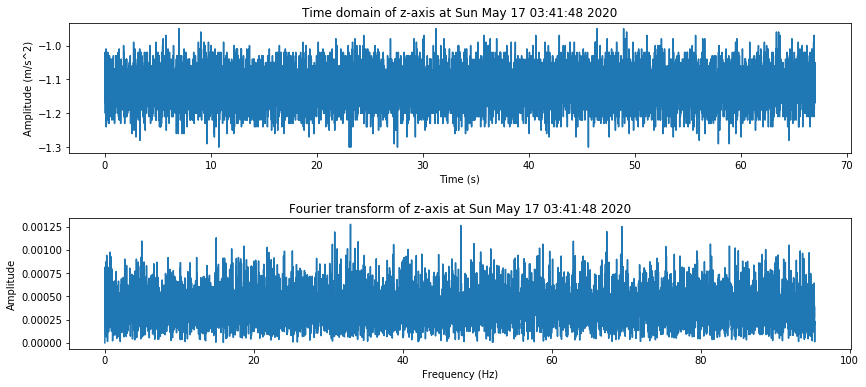

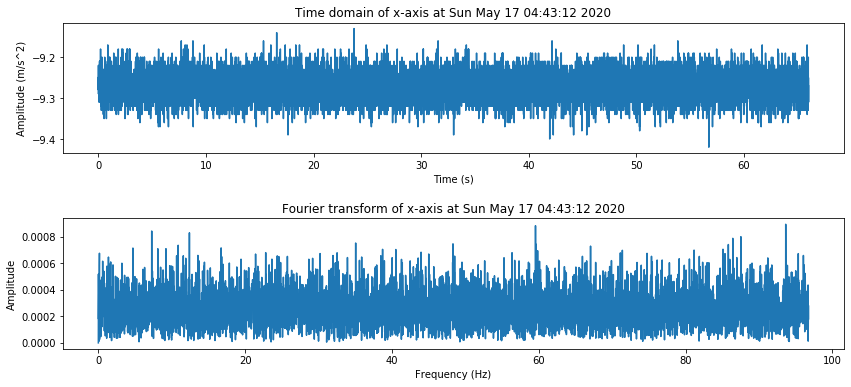

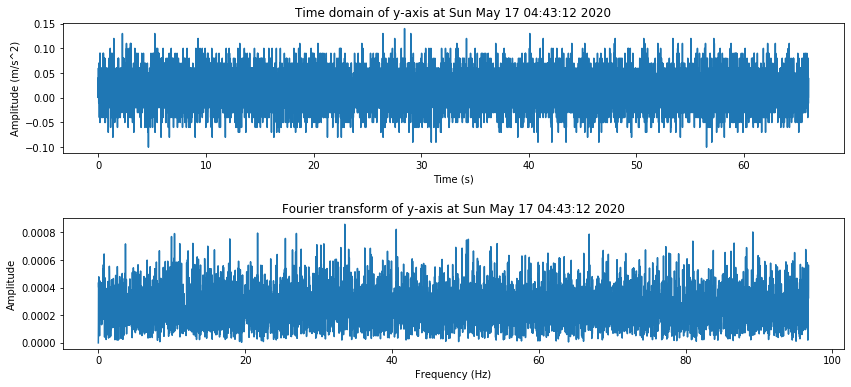

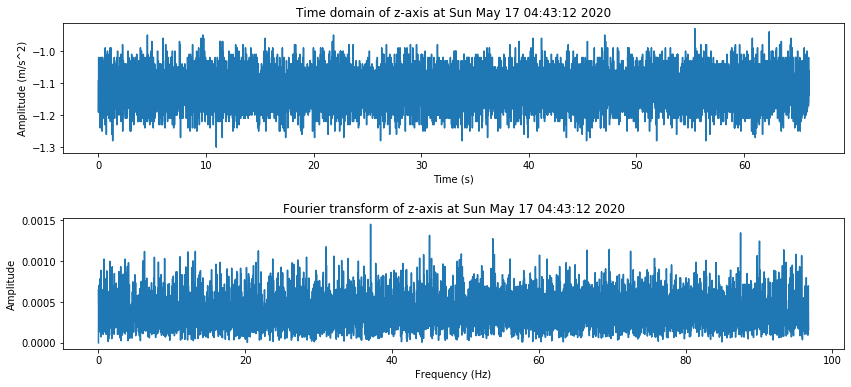

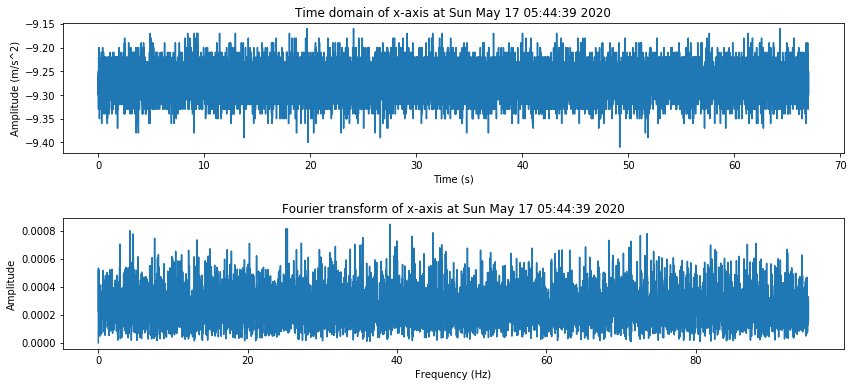

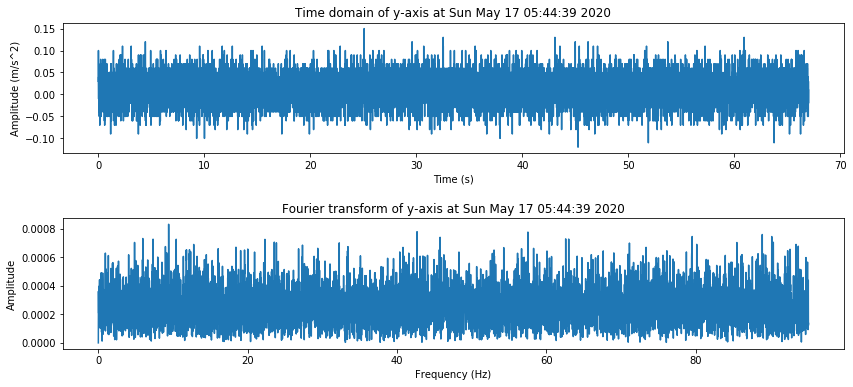

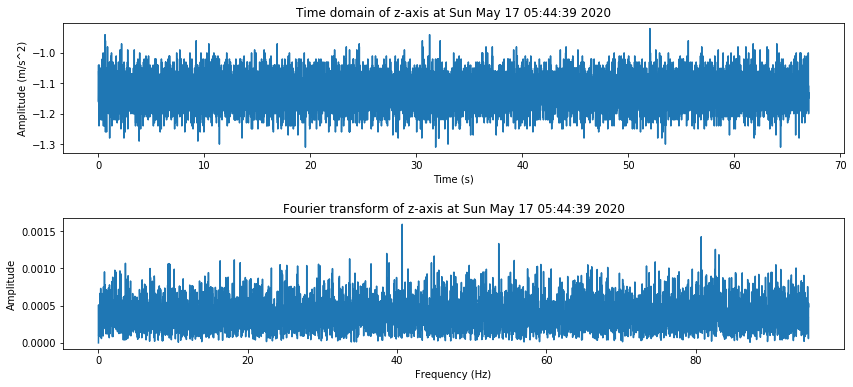

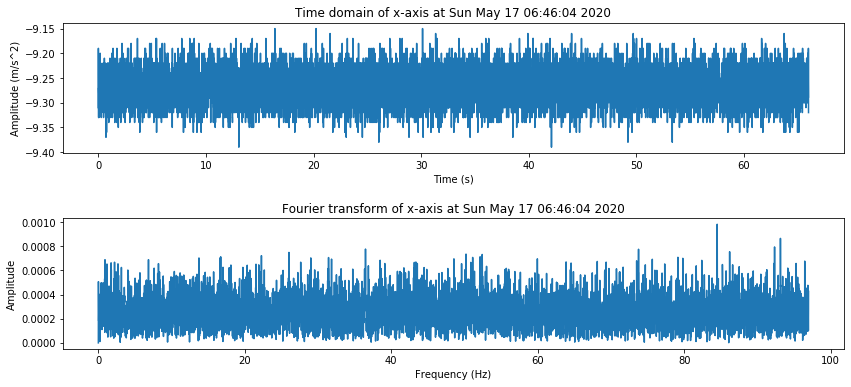

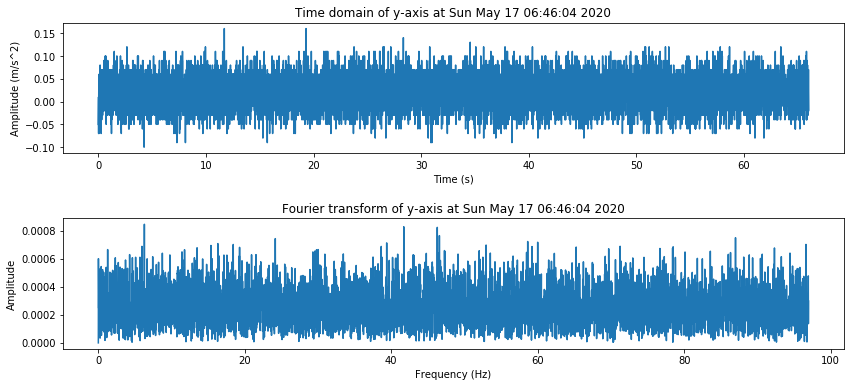

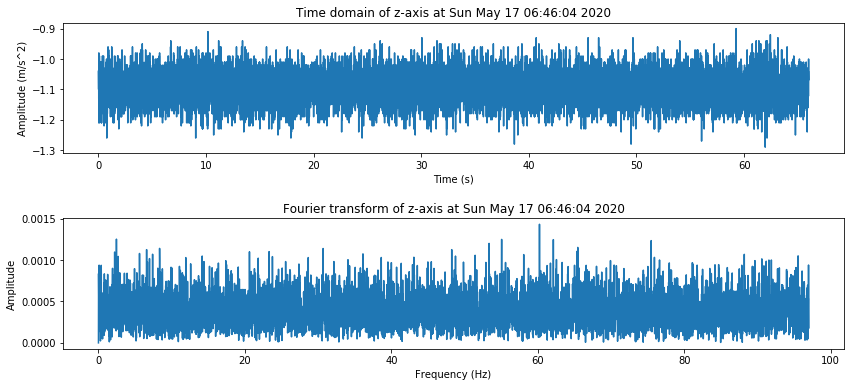

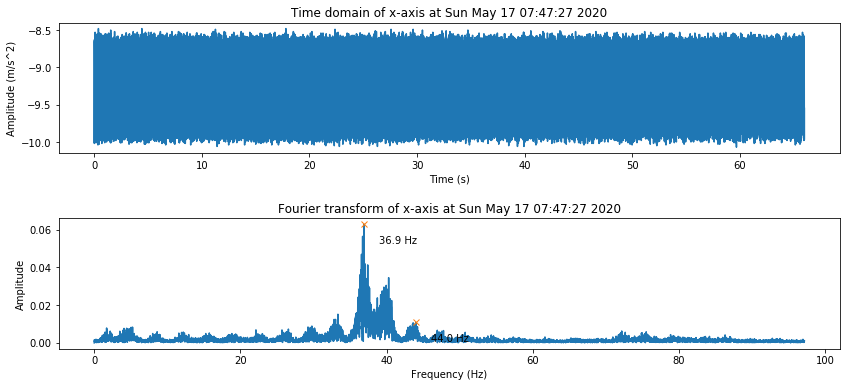

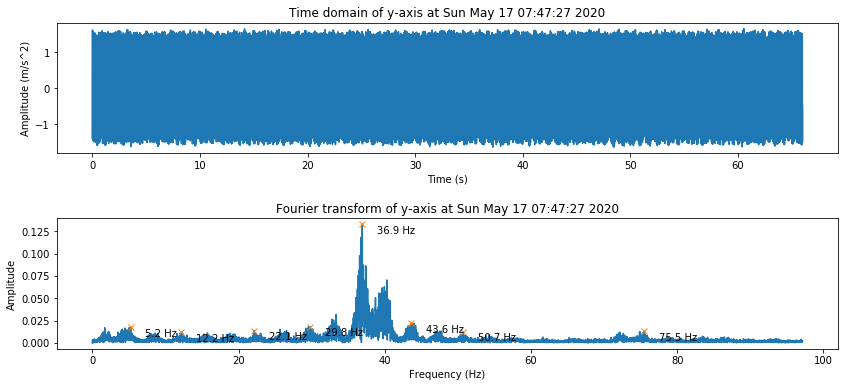

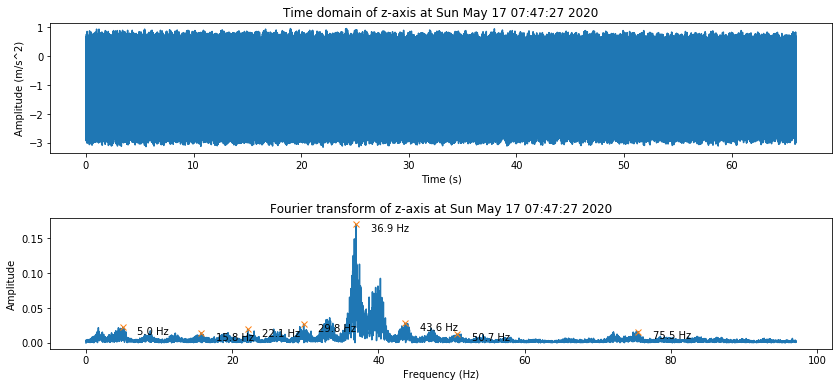

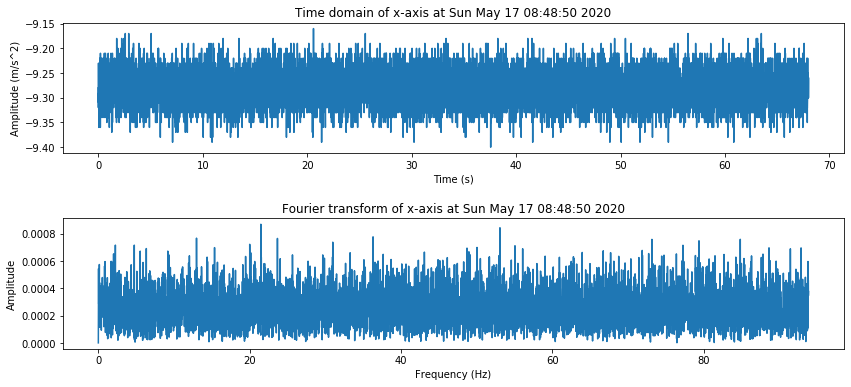

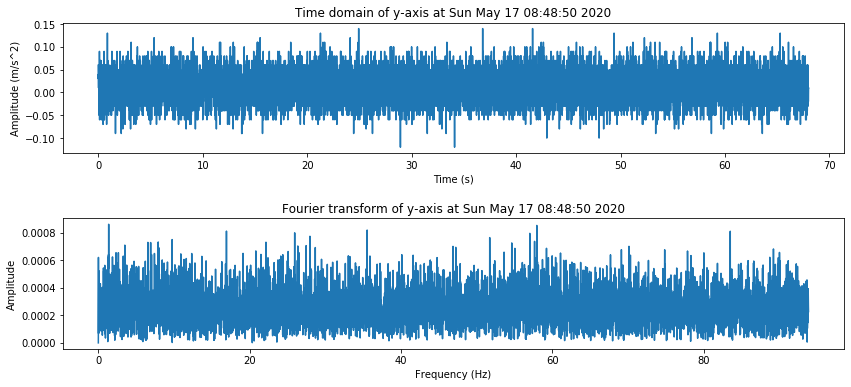

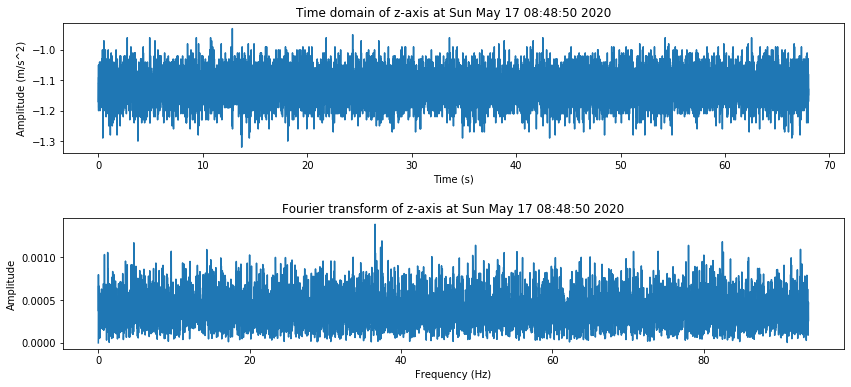

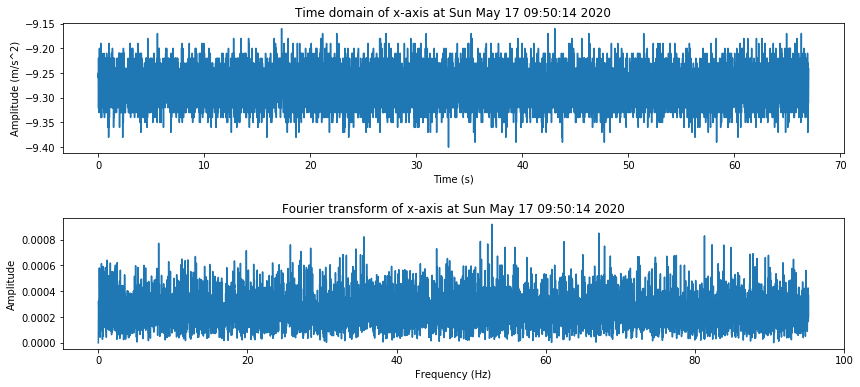

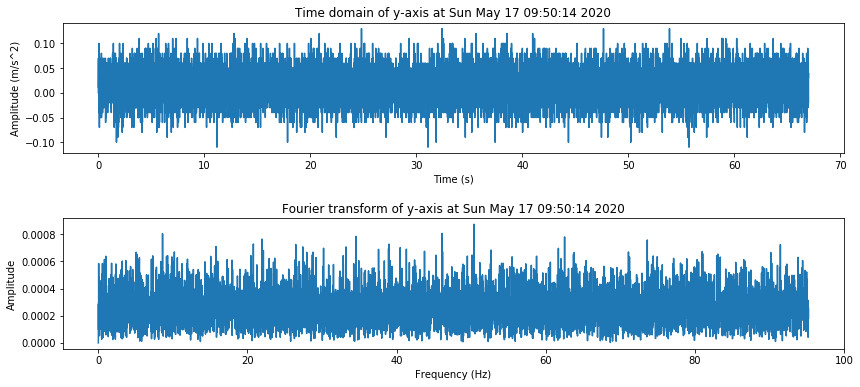

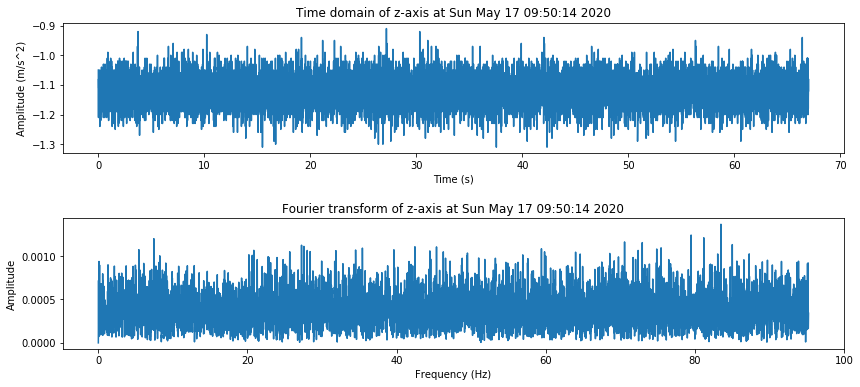

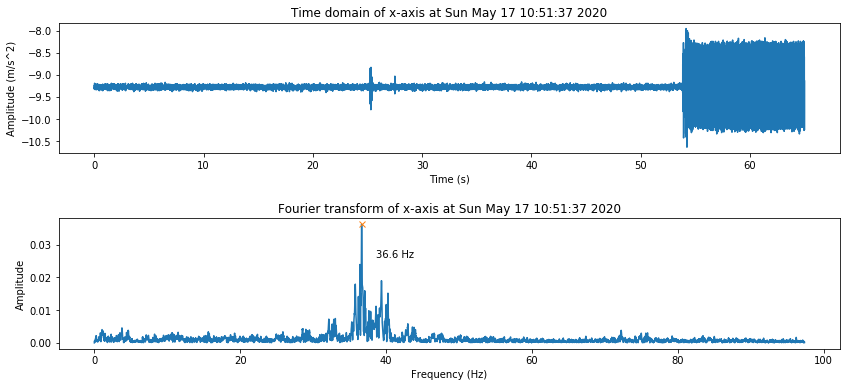

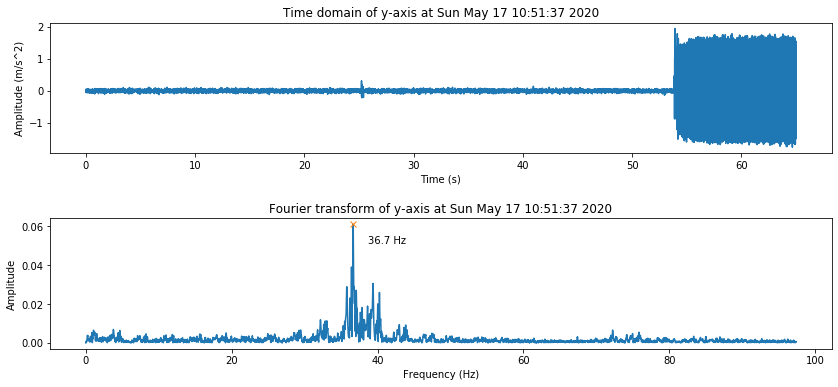

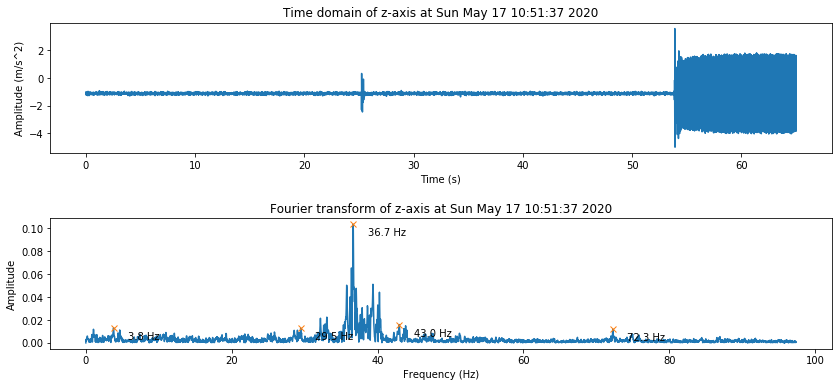

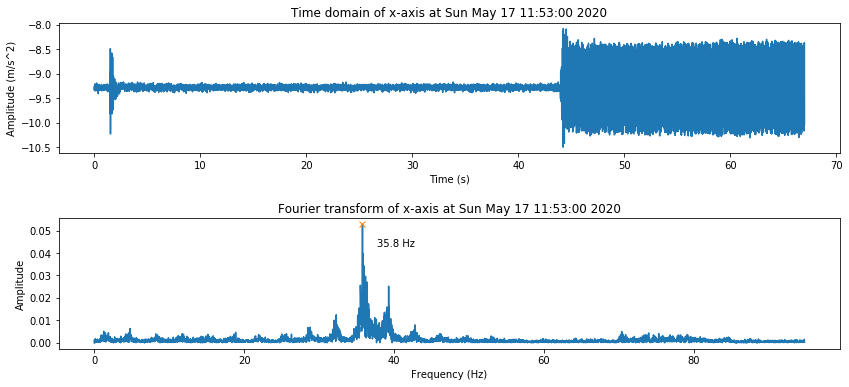

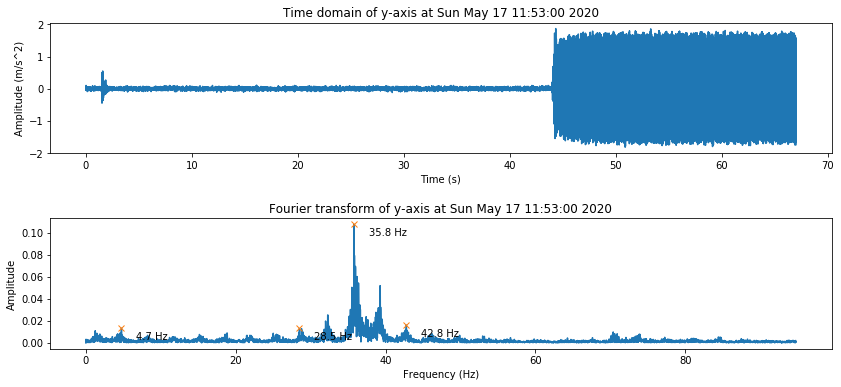

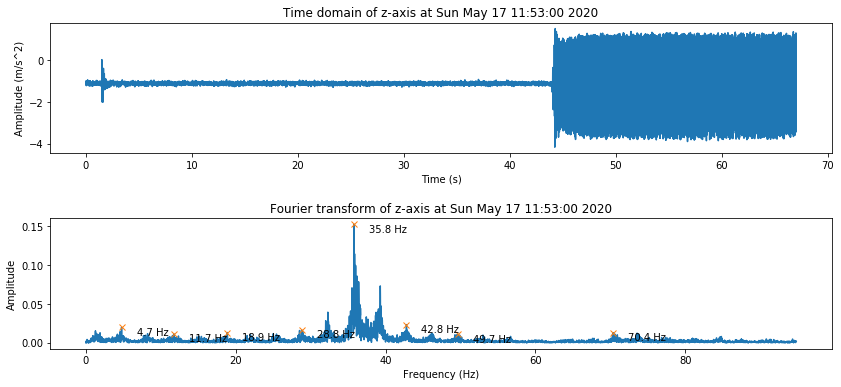

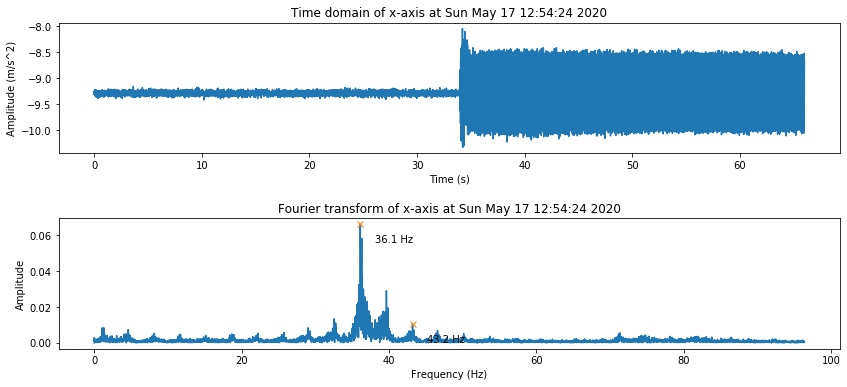

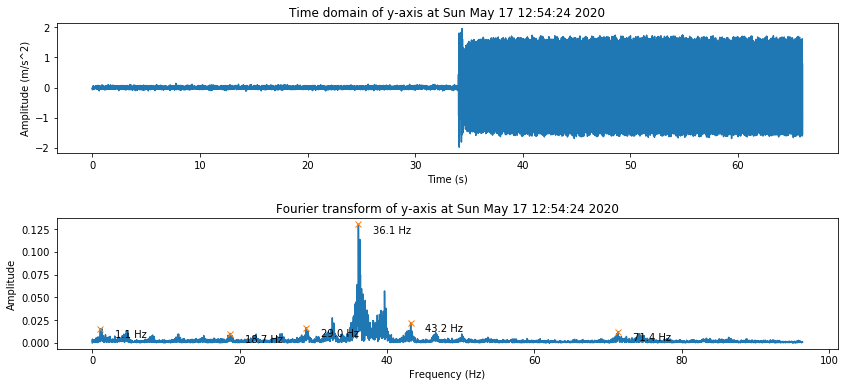

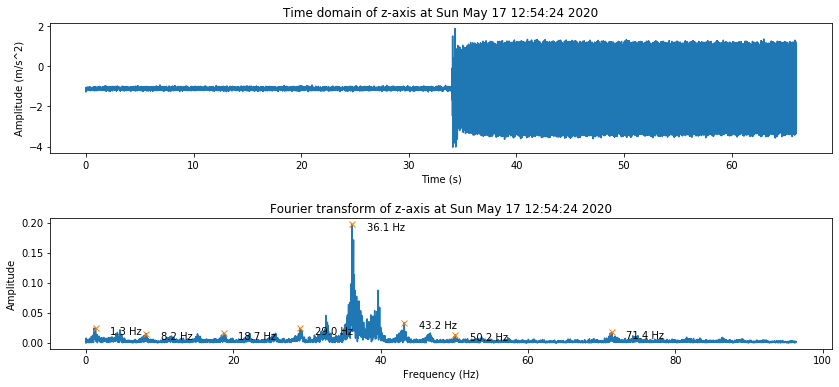

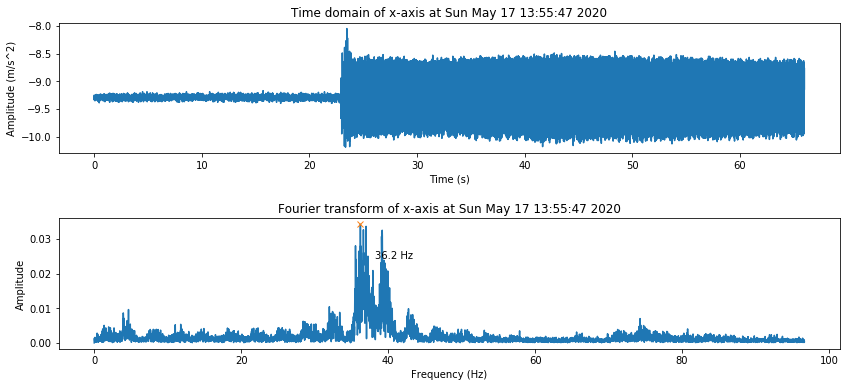

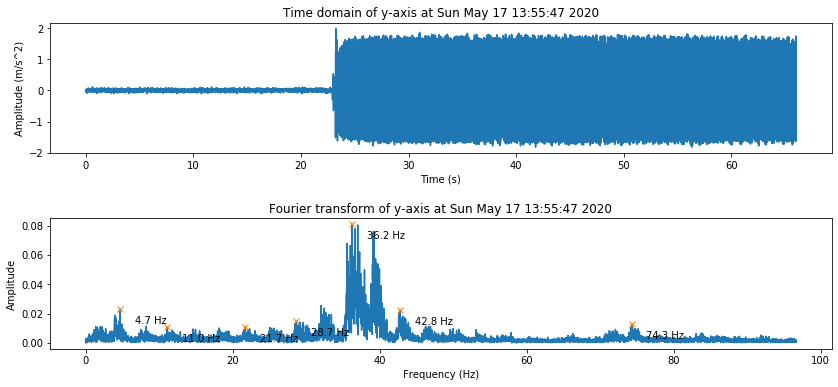

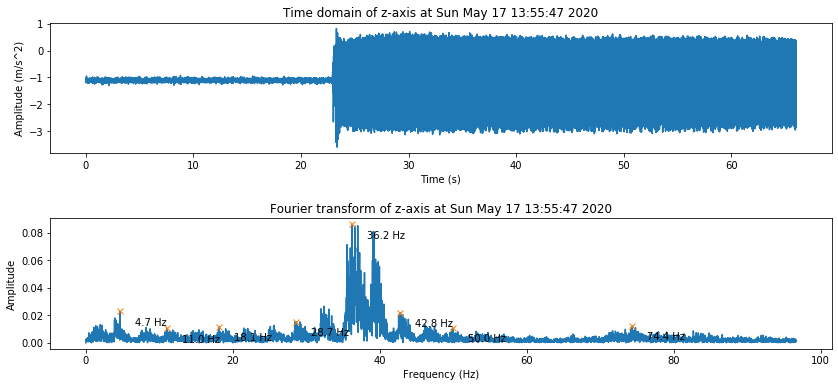

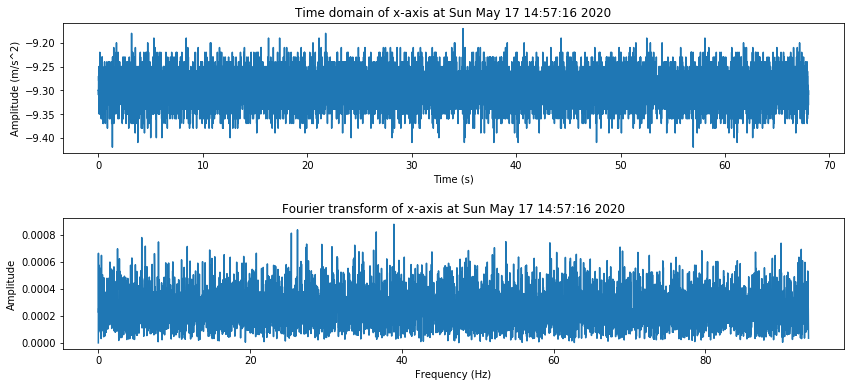

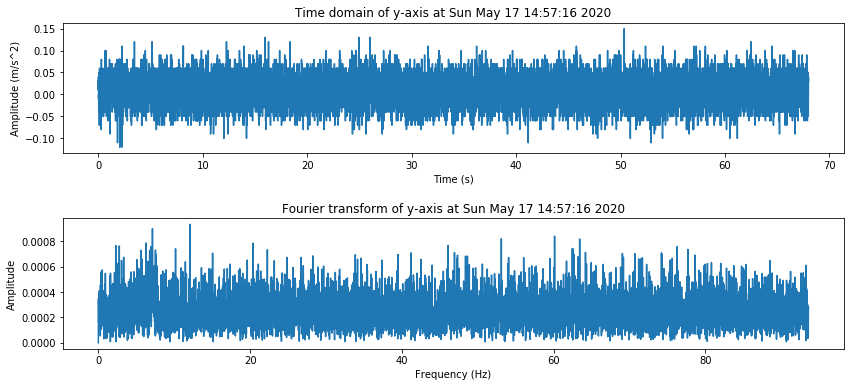

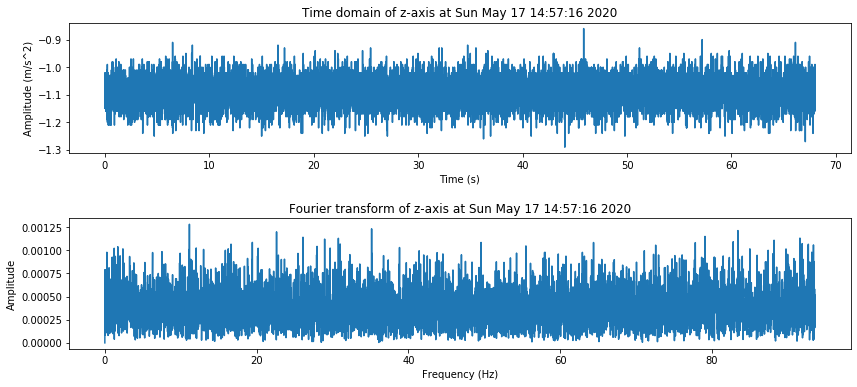

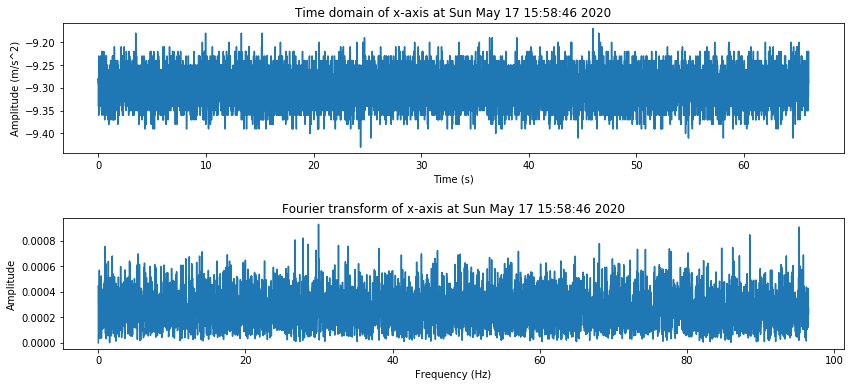

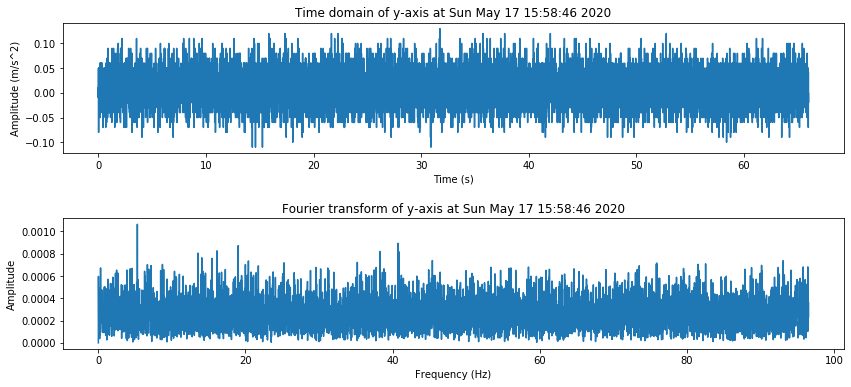

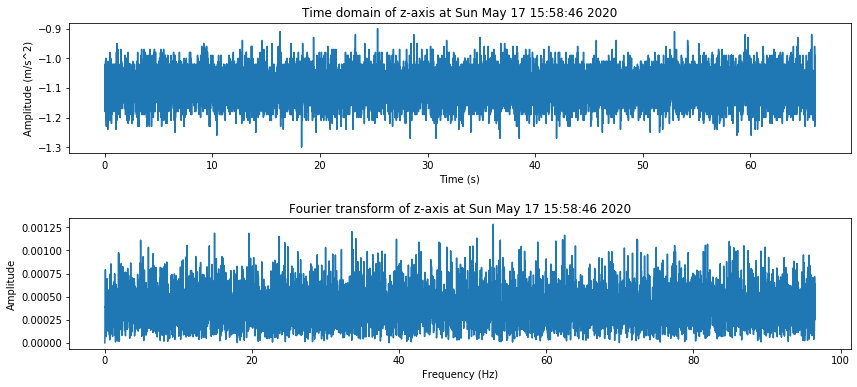

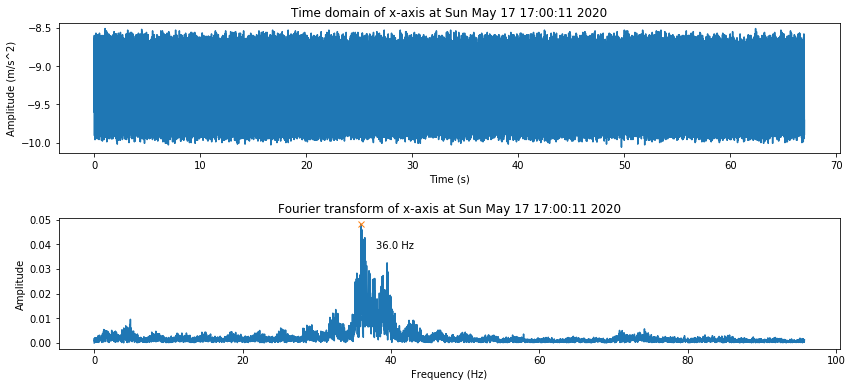

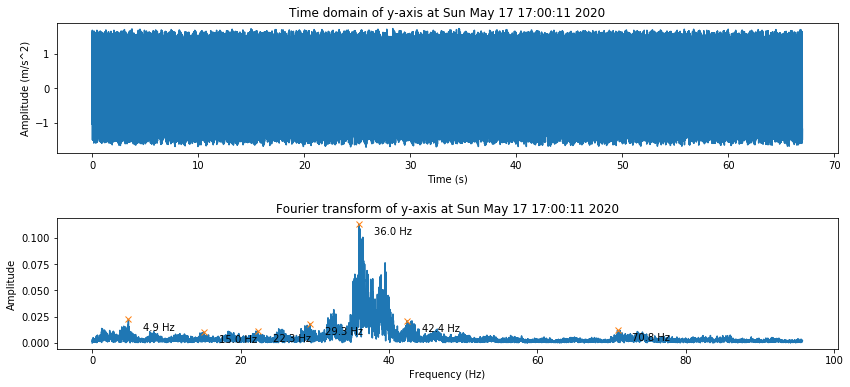

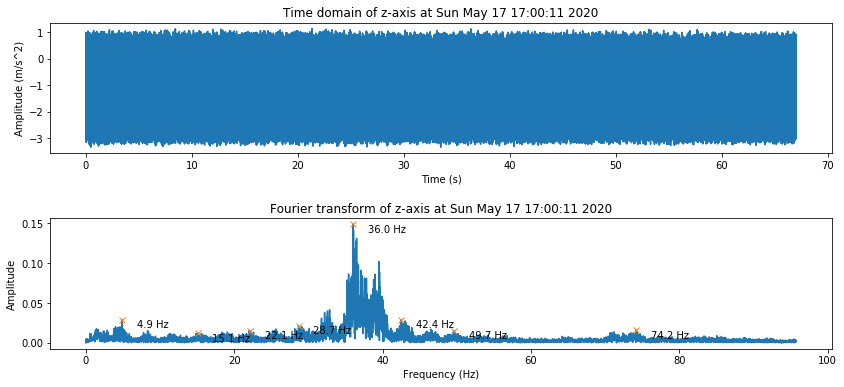

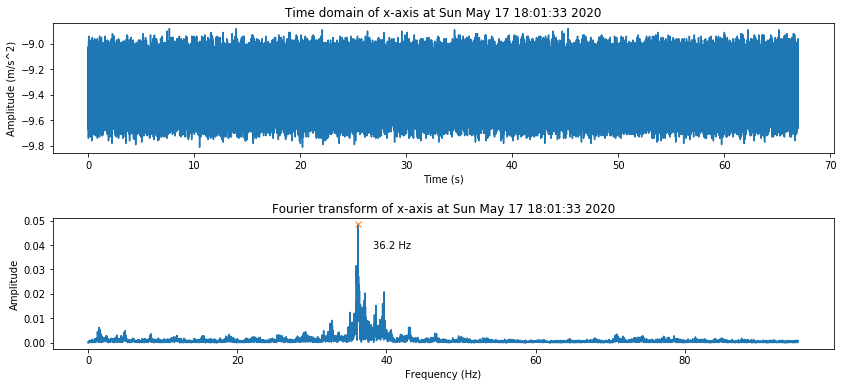

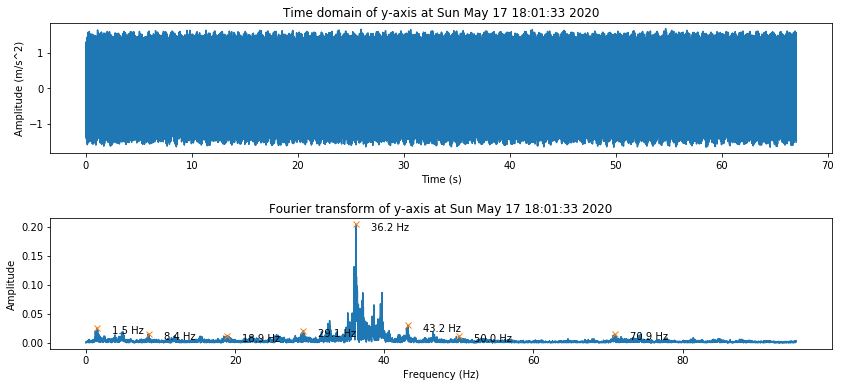

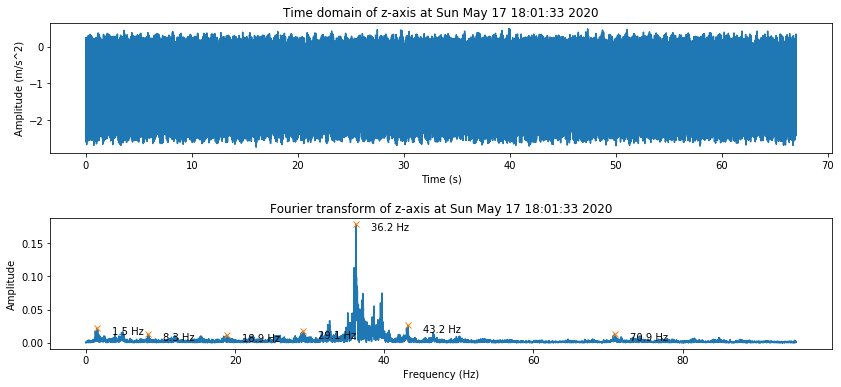

In [8]:
data_dir = "DataVB-collection"
time_string = len(data_dir) + 1

for doc in os.listdir(data_dir):
    address = os.path.join(data_dir, doc)
    if address.endswith('.csv'):
        
        # extracting collection's start and end time from the name of the file
        time1 = float(address[time_string:time_string+10]) 
        time2 = float(address[time_string+11:time_string+22])
        
        # importing the file with pandas
        df = pd.read_csv(address, names=["x","y","z","c"], sep=",",dtype={"x": np.float32, "y": np.float32, "z": np.float32, "c": np.float32})
        
        # defining the time of each measurement (assuming equal spacing between measurements)
        time_points = df.shape[0]
        tm = np.linspace(0,time2-time1,time_points)
        
        # signals of the 3 directions
        x = df["x"].to_numpy()
        y = df["y"].to_numpy()
        z = df["z"].to_numpy()
        
        # calling time_freq_plot() for calculation and plotting of the x-series
        ampl1 = x
        axis = 'x'
        smpl_freq = len(ampl1)/(time2-time1)
        time_freq_plot(tm, ampl1, smpl_freq, axis, time1)
        
        # calling time_freq_plot() for calculation and plotting of the y-series
        ampl1 = y
        axis = 'y'
        smpl_freq = len(ampl1)/(time2-time1)
        time_freq_plot(tm, ampl1, smpl_freq, axis, time1)
        
        # calling time_freq_plot() for calculation and plotting of the z-series
        ampl1 = z
        axis = 'z'
        smpl_freq = len(ampl1)/(time2-time1)
        time_freq_plot(tm, ampl1, smpl_freq, axis, time1)

## Analysis
The sequence of plots prompts us to make the following observations:

1. The time domain plots enable us to identify the moments in which the fridge went "on" or "off", the downtimes being clearly identified by immediate decrease in the amplitude of oscillation. Another marker of the downtimes is the stochastic character of the spectrum.
2. As for the frequency domain plots, they enable us to identify the rotational frequency ("1X") of the compressor. As seen in the latest collections, it is around 36 Hz, which amounts to 2160 RPM.
3. However, the rotational frequency has varied between some collections: in the samples corresponding to the first 2 hours, the frequency was 54.6 and 45.9 Hz respectively, which is indicative of overload or malfunction. In the samples in which the compressor was off the spectrum is stochastic, as already noticed, and in the remaining samples there has been some variance of the main frequency around 36 Hz.
4. The frequency domain plots also display other frequencies. A typical example can be seen in the very first plot (May 16, 22:34:58, x-axis), in which 3 frequencies prevail: 2.9 Hz, 54.6 Hz and 106.2 Hz. The second one (54.6) is clearly the rotational frequency, as we observed above, but the other two seem to be asynchronous.
5. In fact, I tried to examine whether the highest frequency could be the 2X harmonic. For that matter, I zero-padded the signal in order to improve resolution and maybe identify a perfect 2:1 proportion. I used this code to extend the signal:

<code>tm = np.linspace(0,time2-time1,65536)
ampl1 = y
npad = 65536 - len(ampl1)
ampl1 = np.pad(ampl1, pad_width=npad, mode='constant', constant_values=0)[npad:]
</code>

6\. However, the highest frequency remained very close to 2X the rotational frequency, but never exactly. The implications of this observation will be discussed in the following sections.

7\. All the frequency domain plots for uptime samples display many sidebands around the rotational frequency.

8\. The increase of rotational frequency in the first two samples was accompanied by increase in vibration amplitude (between 2 to 4 times).

## II. TIMESERIES ANOMALY DETECTION FOR THE DETECTION OF TURNING OFF EVENTS

Since compressors, like many industry equipments, are designed to be on most of the time, it is useful for a monitoring device to be able to automatically identify if and when the machine has undergone a malfunction, power outage or turning off event.

In this work I use a reconstruction convolutional autoencoder model build with TensorFlow Keras to detect turning off events on the vibration data files. The present model was based on the one proposed by Pavithra Vijay and can be appreciated on Keras documentation (<https://keras.io/examples/timeseries/timeseries_anomaly_detection/>). 

In [9]:
# Importing Keras

from tensorflow import keras
from tensorflow.keras import layers

## Loading training and test data

In this experiment I will use two files. The first one corresponds to data collected on normal functioning conditions and will be used as training data. The second file corresponds to a collection that registered a turning off event and will be used as testing data.

In [11]:
# Let's import the first file and put it in a Pandas dataframe.
df = pd.read_csv('DataVB-collection/1589749293-1589749360.csv', names=["x","y","z","c"], sep=",",dtype={"x": np.float32, "y": np.float32, "z": np.float32, "c": np.float32})
df=df.drop(['x','z','c'], axis=1)
df.shape

(12763, 1)

In [12]:
# Let's import the second file and put it in a Pandas dataframe.
df2 = pd.read_csv('DataVB-collection/1589686645-1589686713.csv', names=["x","y","z","c"], sep=",",dtype={"x": np.float32, "y": np.float32, "z": np.float32, "c": np.float32})
df2=df2.drop(['x','z','c'], axis=1)
df2.shape

(12774, 1)

In [13]:
# Considering sample frequency = 188 Hz and cutting samples at 66s
healthy=np.array(df)
healthy=healthy[:12408]
print(healthy.shape)
healthy[:3]

(12408, 1)


array([[-0.92],
       [-1.35],
       [-0.38]], dtype=float32)

In [14]:
# Considering sample frequency = 188 Hz and cutting samples at 66s
anomalous=np.array(df2)
anomalous=anomalous[:12408]
print(anomalous.shape)
anomalous[:3]

(12408, 1)


array([[-1.16],
       [-1.35],
       [-0.03]], dtype=float32)

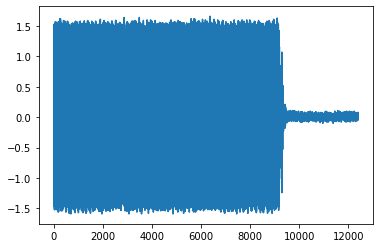

In [15]:
# Let us plot the anomalous sample. It is easily seen that a turning off event occurs at around the 9000th measurement.
plt.plot(anomalous)
plt.show()

In [16]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = healthy.mean()
training_std = healthy.std()
df_training_value = (healthy - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 12408


In [17]:
TIME_STEPS = 188

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (12221, 188, 1)


## Building the model

Let us build a convolutional reconstruction autoencoder model. The shape of the input (and the output) is (batch_size, sequence_length, num_features). In our model, sequence_length is 188 and num_features is 1.

In [26]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 94, 32)            256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 94, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 47, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 94, 16)            1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 94, 16)            0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 188, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 188, 1)           

## Training the model

Since this is a reconstruction model, I use x_train as both the input and the target.

In [27]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
86/86 [==============================] - 5s 55ms/step - loss: 0.3192 - val_loss: 0.1046
Epoch 2/50
86/86 [==============================] - 5s 64ms/step - loss: 0.1086 - val_loss: 0.0501
Epoch 3/50
86/86 [==============================] - 5s 54ms/step - loss: 0.0705 - val_loss: 0.0303
Epoch 4/50
86/86 [==============================] - 5s 53ms/step - loss: 0.0530 - val_loss: 0.0213
Epoch 5/50
86/86 [==============================] - 6s 69ms/step - loss: 0.0425 - val_loss: 0.0163
Epoch 6/50
86/86 [==============================] - 6s 69ms/step - loss: 0.0357 - val_loss: 0.0130
Epoch 7/50
86/86 [==============================] - 6s 70ms/step - loss: 0.0313 - val_loss: 0.0113
Epoch 8/50
86/86 [==============================] - 6s 72ms/step - loss: 0.0285 - val_loss: 0.0101
Epoch 9/50
86/86 [==============================] - 6s 70ms/step - loss: 0.0263 - val_loss: 0.0090
Epoch 10/50
86/86 [==============================] - 5s 56ms/step - loss: 0.0246 - val_loss: 0.0085
Epoch 11/

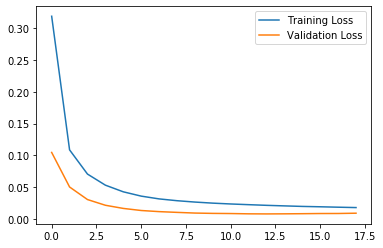

In [28]:
# We can observe the training's progress
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detection of anomalies

Our analysis follows three steps:

1. Finding MAE loss on the training samples.

2. Finding maximum MAE loss value. This indicates the worst performance of our model when trying to reconstruct a sample. This will be the threshold for anomaly detection.

3. We will identify as anomalous all samples for which the reconstruction loss is greater than the threshold value. We can presume that in such samples the model is observing a pattern that isn't familiar.

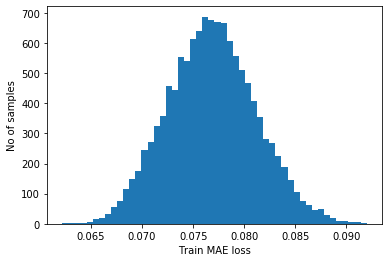

Reconstruction error threshold:  0.091973245


In [29]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

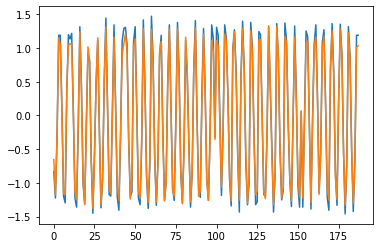

In [30]:
# Let us check how the model is able to reconstruct the signal (here we take the first sequence of the training data).
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

## Preparing test data and identifying samples containing the turning off event

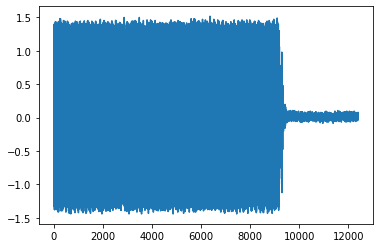

Test input shape:  (12221, 188, 1)


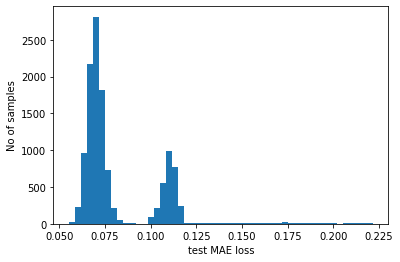

Number of anomaly samples:  3190
Indices of anomaly samples:  (array([ 9028,  9032,  9033, ..., 12218, 12219, 12220], dtype=int64),)


In [33]:
df_test_value = (anomalous - training_mean) / training_std
#df_test_value = (anomalous - anomalous.mean()) / anomalous.std()
plt.plot(df_test_value)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

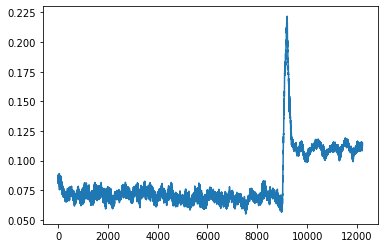

In [34]:
# Let us plot MAE loss for testing data.
plt.plot(test_mae_loss)
plt.show()

## Conclusion

The above graph plots MAE loss for testing data. As we can visually inspect, the spike around 9000 clearly marks the turning off event.

In this way we demonstrate that a permanent and automatic monitoring system can use the maximum MAE loss value as a threshold to identify atypical events.

## III. ANALYSIS ON THE CONDITION OF THE COMPRESSOR

Although this was intended to be an experiment on the use of neural networks to system monitoring, especially anomaly detection, we can also advance some analysis on the overall state of the compressor (based on spectral analysis). There is one caveat: original data displayed no information on the type or brand of the compressor and no discrimination of the measurement positions (axial/radial) were provided. This only made the whole diagnosis process a bit more guessy.

ANALYSIS

The compressor seems to be defective. I reached this conclusion based on the following remarks:

1. UPTIME PROPORTION. A number of references I found state that the fridge compressor should be on most of the time. For instance: "It is typical for a refrigerator compressor to run anywhere between 4 to 8 hours straight before shutting off.  In fact, newer refrigerators are expected to constantly run 80-90 percent of their lifetime." (retrieved on June 22nd, 2021 from <https://myappliancerepairnaperville.com/refrigerator-compressor/>) Considering all collection files, total uptime was 35.6%. Thus this is the first sign of defective behaviour.

2. ROTATION VARIANCE. There were two samples (the first and the second) in which rotation frequency was considerably higher than normal (respectively 54.6 and 45.9 Hz, against a normal value of 36 Hz). Apart from those samples, there has been some variance in rotation frequency (roughly between 35 and 37 Hz) throughout the whole set. This is indicative of abnormal functioning.

3. UNBALANCING. The steep spikes in the rotation frequency (1X) that the frequency domain plots display in all directions is highly suggestive of unbalancing (see, for instance, Kameshwar Upadhyay, "Basics of Vibration and Condition Analysis", Notion Press, Chennai, 2020).

4. BEARING PROBLEM. In the frequency domain plots of the whole dataset we observe the presence of peaks that are not harmonics of the rotation frequency (1X). In fact there is always the presence of an asynchronous tone very near 2X (a typical example can be seen in the very first plot (May 16, 22:34:58, x-axis), in which 3 frequencies prevail: 2.9 Hz, 54.6 Hz and 106.2 Hz. The second one (54.6) is the rotational frequency and the third one falls just to the side of the 2X harmonic). In addition, we frequently observe the presence of many sidebands around 1X (the last collection is a typical example). According to the article "Understanding the Role of Linearity in Vibration Analysis" (retrieved on June 22nd, 2021 from <https://www.efficientplantmag.com/2003/09/understanding-the-role-of-linearity-in-vibration-analysis/>), "Rolling element bearing wear, gear defects, and motor-bar defects will produce sidebands. Rolling element bearings also will create nonsynchronous tones. These are new peaks that are not exact multiples (harmonics) of the shaft rate."

A remark about MISALIGNMENT. If I am right to infer that the frequency domain plots don't display the 2X tone (see above), then I can conclude that there are no grounds to assume machine misalignment.